In [1]:
#connect database and create cursor 
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as sp
from scipy import stats

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

Null Hypothesis: H_0 = There is no relationship between the "Discount" and the "Quantity" of a product in an order. 

Alternative Hypothesis: H_1 = There is a relationship between the discount and the quantity of a product in an order. (the more of a discount, the higher the quantity is ordered)

In [3]:
#wrap the results into a Pandas DataFrame and re-assign column names
c.execute('''SELECT Quantity, Discount FROM OrderDetail ORDER BY Quantity DESC;''')
df = pd.DataFrame(c.fetchall())
df.columns = [column[0] for column in c.description]
df.head()

,Quantity,Discount
0,130,0.1
1,130,0.0
2,120,0.1
3,120,0.1
4,120,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


In [5]:
df.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


Hypothesis Testing:
experimental design, effect size, T-tests, Type 1 and Type 2 errors

p-value: the probability of observing a test statistic at least as large as the one observed, by random chance, assuming the null hypothesis is true 

alpha value: the marginal threshold at which you're okay with rejecting the null hypothesis (most commonly 0.05)

A One-Tail Test is when you want to know if a parameter from the treatment group is greater than (or less than) a corresponding parameter from the control group.

Effect size using Cohen's D statistic:
Effect Size is used to quantify the size of the difference between two groups under observation
P value - probability sample means are the same.
(1 - P) or Confidence Level = probability sample means are different
Effect size = how different sample means are

What kind of hypothesis test here?
Two sample t-tests? - used to determine if two population means are equal 

In [6]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.04       1
0.01       1
0.06       1
Name: Discount, dtype: int64

In [7]:
df.Quantity.value_counts()

20     252
30     194
10     181
15     169
40     113
12      92
6       87
25      80
50      75
35      71
5       67
24      58
60      58
4       55
2       52
21      50
8       50
18      47
3       46
14      36
16      35
9       30
28      29
70      28
7       23
36      21
42      19
1       17
80      16
45      14
100     10
55       9
120      8
65       8
49       7
48       5
32       5
44       4
90       4
13       3
77       3
110      3
56       3
84       2
11       2
27       2
33       2
39       2
130      2
63       1
66       1
22       1
52       1
54       1
91       1
Name: Quantity, dtype: int64

In [8]:
no_discount = df[df.Discount == 0]['Quantity']
no_discount.head()

1     130
4     120
6     120
7     120
10    110
Name: Quantity, dtype: int64

In [9]:
discount5 = df[df.Discount == 0.05]['Quantity']
discount10 = df[df.Discount == 0.10]['Quantity']
discount20 = df[df.Discount == 0.20]['Quantity']
discount15 = df[df.Discount == 0.15]['Quantity']
discount25 = df[df.Discount == 0.25]['Quantity']

In [10]:
all_discounts = df[df.Discount != 0]['Quantity']

In [11]:
#Initial mean exploration
print(no_discount.mean())
print(all_discounts.mean())

21.715261958997722
27.10978520286396


Use an "ANOVA" test for the different discount levels maybe two sample t-test to see discount vs no discount

a 2-category ANOVA F-Test is Equivalent to a 2-Tailed t-test

Welch's T-test is when the assumptions of equal sample sizes and variances are not met

also use Welch's T-test for distributions that do not have a normality assumption

In [12]:
#Generating the ANOVA Table: function for ANOVA table
def ANOVA_Quantity_Discount(df):
    formula = 'Quantity ~ C(Discount)'
    lm = ols(formula, df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table)

In [13]:
ANOVA_Quantity_Discount(df)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


scipy.stats.f_oneway: 
The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
The test is applied to samples from two or more groups, possibly with differing sizes.

Dont need to check for data following a normal distribution because number of observations (n) is greater than 50. By the Central Limit Theorem (CTL), when independent random variables are added, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed

In [14]:
sp.stats.f_oneway(no_discount, discount5, discount10, discount15, discount20, discount25)

F_onewayResult(statistic=9.798709497651325, pvalue=2.840680781326738e-09)

Reject the null hypothesis, given our p value is < 0.05.
At least two group means are statistically different from each other. There is a statistically significant chance that there is a relationship between the "Discount" and "Quantity" of a product in an order
You cannot tell which specific groups were statistically signifcantly different from each other, only that at least two groups were.
Perform a t-test comparing these different groups and graph it out using a violin plot of the different Discount levels and Quantities of orders

Do I need an "Effect size"(how different sample means are) or "Power"?

In [15]:
#perform t-test (welch's t-test )
#use scipy.stats.ttest_ind
#build a function for this and include effect size/cohen's D stat
#stats.ttest_ind is a two-sided test, equal_var=False makes it welch (different variances and sample sizes)
def t_test_discount(discountamount):
    t, p = sp.stats.ttest_ind(no_discount, discountamount, equal_var=False)
    print('t:',t)
    print('p:',p/2)

In [16]:
t_test_discount(discount5)

t: -3.7008442607608716
p: 0.00013616747216423758


In [17]:
t_test_discount(discount10)

t: -2.0944342819334767
p: 0.01872798305317041


In [18]:
t_test_discount(discount15)

t: -3.835662042660593
p: 8.610364721813697e-05


In [19]:
t_test_discount(discount20)

t: -3.4021239132172787
p: 0.0004055016627021704


In [20]:
t_test_discount(discount25)

t: -3.8572676240072523
p: 7.961525461062818e-05


All discount levels appear to be statistically significant and merit rejecting the null-hypothesis based on the p-values.
Most signficiant discount levels are: 25%, 15%, 5%, 20%, 10% in that order

Check effect size using Cohen D:

In [21]:
def cohensd(group1, group2):
    return (group1.mean() - group2.mean())/((math.sqrt(group1.std()**2+group2.std()**2))/2)

In [22]:
cohensd_discount5 = cohensd(no_discount, discount5)
cohensd_discount5

-0.4454951901792902

In [23]:
cohensd_discount10 = cohensd(no_discount, discount10)
cohensd_discount10

-0.25627339218872913

In [24]:
cohensd_discount15 = cohensd(no_discount, discount15)
cohensd_discount15

-0.48874636877827726

In [25]:
cohensd_discount20 = cohensd(no_discount, discount20)
cohensd_discount20

-0.4129793473738977

In [26]:
cohensd_discount25 = cohensd(no_discount, discount25)
cohensd_discount25

-0.48929277482188704

All the Cohen D statistics are larger than 0.2 and close to 0.5 which is defined to be a "medium" effect size

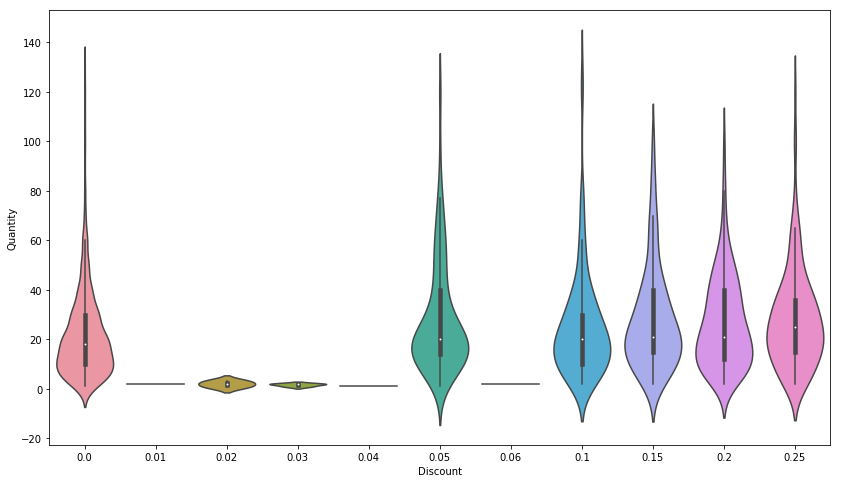

In [27]:
#create a violin plot in seaborn to compare the different discount levels and visualize effect size on mean Quantity of order
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='Discount', y='Quantity', data=df, scale='width')
#ax.set(ylim=(-10,50))

In [28]:
#conduct a Power analysis 
#Power of a statistical test is defined as the probability of rejeecting the null hypothesis, given that it is indeed false.
#ranges from 0 to 1
#related to beta, the probability of Type 2 errors (alpha is probability of type 1 errors, reject null-hypothesis when actually true)
#power = 1 - beta

from statsmodels.stats.power import TTestIndPower, TTestPower

power_analysis = TTestIndPower()

In [29]:
#function to calculate power with 2 samples and cohen d for effect size
#alternative='smaller' is to indicate a one-sided test - to the left or the right of the sample
def powertest(sample1, sample2, cohensd):
    power = power_analysis.solve_power(effect_size=cohensd, nobs1=len(sample1), alpha=0.05, ratio=len(sample2)/len(sample1), alternative='smaller')
    return power

In [30]:
powertest(no_discount, discount5, cohensd_discount5)

0.9999999930235985

In [31]:
powertest(no_discount, discount10, cohensd_discount10)

0.9360874911711115

In [32]:
powertest(no_discount, discount15, cohensd_discount15)

0.9999999964523446

In [33]:
powertest(no_discount, discount20, cohensd_discount20)

0.9995154605974645

In [34]:
powertest(no_discount, discount25, cohensd_discount25)

0.9999999954131694

All of the powers are very high, meaning beta (probability of Type 2 Errors) is very low.
This is ideal because it means the probability of a Type 2 Error is very low. 
Type 2 Errors are a non-rejection of a false null-hypothesis, aka a false negative

Business recommendation:
The discount levels have a statistically significant impact on Quantities of orders, however, the effect sizes are in the small to medium size range.

The effect sizes being small to medium means the actual mean increase in Quantities of orders isnt that large. More work should be done to analyze if the % discount is worth the "small to medium increase" in Quantities of orders. 

Without doing any more work on this I would be inclined to recommend a 5% discount on most items because the effect size is almost as large as a 25% discount. This means while you will increase the Quantities of orders "significantly" you also won't hurt your profitability as much with a 5% discount.

Hypothesis Test Number Two:

Null Hypothesis: H_0 = ShipVia has no effect/relationship on the Freight

Alternative Hypothesis: H_1 = ShipVia does have an effect/relationship on the Freight

In [35]:
#wrap the results into a Pandas DataFrame and re-assign column names
c.execute('''SELECT * FROM [Order];''')
df2 = pd.DataFrame(c.fetchall())
df2.columns = [column[0] for column in c.description]
df2.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB


In [37]:
df2.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

In [38]:
#convert to datetime objects
df2['RequiredDate'] = pd.to_datetime(df2['RequiredDate'])

In [39]:
#convert to datetime objects
df2['ShippedDate'] = pd.to_datetime(df2['ShippedDate'])

In [40]:
#convert to datetime objects
df2['OrderDate'] = pd.to_datetime(df2['OrderDate'])

In [41]:
#add a new column to this dataframe to show the days to ship
df2['DaysToShip'] = df2['ShippedDate'] - df2['OrderDate']

In [42]:
#add a new column to this dataframe to show the days past the required date
df2['DaysLate'] = df2['ShippedDate'] - df2['RequiredDate']

In [43]:
df2.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,DaysToShip,DaysLate
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,12 days,-16 days
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5 days,-37 days
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,4 days,-24 days
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,7 days,-21 days
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2 days,-26 days


In [44]:
df2.DaysToShip.mean()

Timedelta('8 days 11:48:25.809641')

In [45]:
df2.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

In [192]:
shipvia1 = df2[df2['ShipVia'] == 1]['Freight']
shipvia2 = df2[df2['ShipVia'] == 2]['Freight']
shipvia3 = df2[df2['ShipVia'] == 3]['Freight']

In [193]:
#Explore averages
print(shipvia1.mean())
print(shipvia2.mean())
print(shipvia3.mean())

65.00132530120482
86.6406441717791
80.44121568627443


In [194]:
#conduct an ANOVA f-test, two-tail test
sp.stats.f_oneway(shipvia1, shipvia2, shipvia3)

F_onewayResult(statistic=2.49781040377206, pvalue=0.08288539205995446)

Fail to reject the null hypothesis given the p-value is > 0.05 (alpha). There isn't a statistically significant effect of ShipVia on the number of days to ship. 

Any need to proceed further with t-tests, effect size, power analysis? - The p-value is almost smaller than 0.05. 

Would recommend to the company to continue using all 3 ShipVia's because the DaysToShip doesn't seem to be very different across the 3 different Shippers.

In [195]:
#explore a t-test for fun
def t_test_freight(sample1, sample2):
    t, p = sp.stats.ttest_ind(sample1, sample2, equal_var=False)
    print('t:',t)
    print('p:',p/2)

In [196]:
t_test_freight(shipvia1, shipvia2)

t: -2.3979967389897348
p: 0.008417108919771222


In [197]:
t_test_freight(shipvia1, shipvia3)

t: -1.7404246367101424
p: 0.04124961049463819


In [198]:
t_test_freight(shipvia2, shipvia3)

t: 0.5794226261355386
p: 0.281265818929504


Reject the null hypothesis comparing shipvia1 vs shipvia2 and shipvia1 vs shipvia3.
This means ShipVia does have a statistically significant effect on freight if you are comparing shipvia1 to either shipvia2 or shipvia3

In [199]:
#explore effect size:
cohensd(shipvia1, shipvia2)

-0.2748819372338375

In [200]:
cohensd(shipvia1, shipvia3)

-0.21872692022553855

Relatively small effect sizes but still something to note. 

In [201]:
#Explore Power:
powertest(shipvia1, shipvia2, cohensd(shipvia1, shipvia2))

0.9470955448234311

In [202]:
powertest(shipvia1, shipvia3, cohensd(shipvia1, shipvia3))

0.7901280819848711

Low enough betas where Type 2 errors would be minimized.

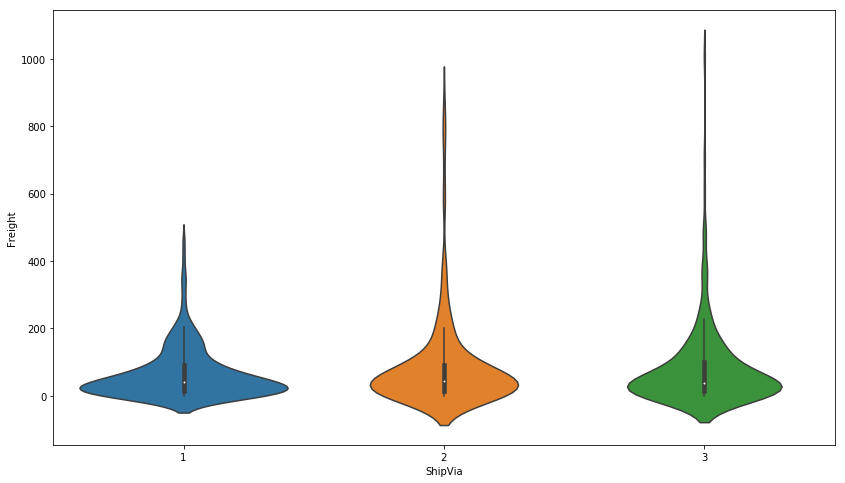

In [204]:
#Visualize this effect:
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='ShipVia', y='Freight', data=df2)

The effect isn't drastic, but I would recommend that the company favor ShipVia1 over the other 2 shippers.
I would also recommend to look into why ShipVia1 has a slightly lower freight cost. Perhaps it has more to do with WHERE they ship to, etc. 

In [228]:
df2[df2.ShipVia == 3]['ShipRegion'].value_counts()

Western Europe     76
North America      56
South America      34
British Isles      28
Southern Europe    18
Northern Europe    15
Central America    14
Scandinavia        10
Eastern Europe      4
Name: ShipRegion, dtype: int64

Hypothesis Test 3: 

Null Hypothesis: H_0 = Ship Region has no effect on Freight cost

Alternative Hypothesis: H_1 = Ship region does have an effect on Freight cost

In [49]:
df2.ShipRegion.value_counts()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Central America     28
Scandinavia         28
Eastern Europe       7
Name: ShipRegion, dtype: int64

In [50]:
western_europe = df2[df2['ShipRegion'] == 'Western Europe']['Freight']
north_america = df2[df2['ShipRegion'] == 'North America']['Freight']
south_america = df2[df2['ShipRegion'] == 'South America']['Freight']
british_isles = df2[df2['ShipRegion'] == 'British Isles']['Freight']
southern_europe = df2[df2['ShipRegion'] == 'Southern Europe']['Freight']
northern_europe = df2[df2['ShipRegion'] == 'Northern Europe']['Freight']
scandinavia = df2[df2['ShipRegion'] == 'Scandinavia']['Freight']
central_america = df2[df2['ShipRegion'] == 'Central America']['Freight']

In [51]:
western_europe.mean()

92.61336956521727

In [52]:
north_america.mean()

105.06171052631578

In [53]:
south_america.mean()

56.64793103448279

In [54]:
british_isles.mean()

76.12679999999997

In [55]:
southern_europe.mean()

37.0290625

In [56]:
northern_europe.mean()

84.25072727272729

In [57]:
scandinavia.mean()

42.37107142857142

In [58]:
central_america.mean()

40.09928571428571

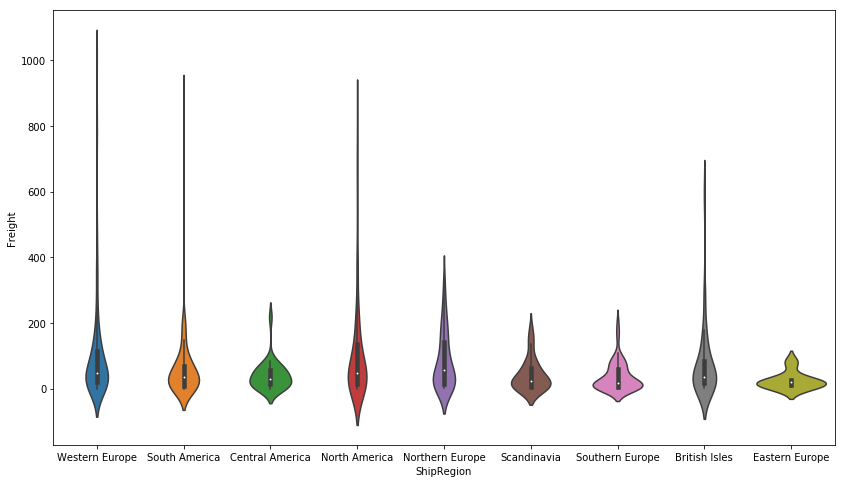

In [206]:
#create a violin plot in seaborn to compare the different discount levels
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='ShipRegion', y='Freight', data=df2)

In [60]:
#perform an ANOVA test
sp.stats.f_oneway(western_europe, south_america, central_america, north_america, northern_europe, scandinavia, southern_europe, british_isles)

F_onewayResult(statistic=4.519652306798359, pvalue=5.873943090044774e-05)

Reject the null hypothesis because our p-value < 0.05. Ship region does have an effect on Freight costs.

Would require too many t-tests to test each combo - lets focus on the top 3 regions - Western Europe, NA, SA

In [213]:
#perform f_oneway test for top 3 ship regions
sp.stats.f_oneway(western_europe, south_america, north_america)

F_onewayResult(statistic=5.860316800334934, pvalue=0.003024895330448529)

In [215]:
#perform t-tests
t_test_freight(western_europe, south_america)

t: 3.343595918720001
p: 0.00045289898181854793


In [216]:
t_test_freight(western_europe, north_america)

t: -0.851674177444107
p: 0.19756623247945126


In [219]:
t_test_freight(north_america, south_america)

t: 3.3900832127982876
p: 0.0004073506775537624


South America appears to have a statistically signficiantly lower freight cost relative to Western Europe and North America

I would recommend that the business try to keep expanding in South America based on the lower freight cost.

In [229]:
#Effect Size
cohensd(western_europe, south_america)

0.4550210927749705

In [230]:
cohensd(north_america, south_america)

0.5532651580116017

Effect sizes are medium to medium-large because they are above 0.4. South America's freight costs appear to be a lot smaller, further supporting my recommendation to the company to pursue more business in South America to reduce costs/improve margins

In [233]:
#power test
power_analysis.solve_power(effect_size=cohensd(western_europe, south_america), nobs1=len(western_europe), alpha=0.05, ratio=len(south_america)/len(western_europe), alternative='larger')

0.9973182495906974

In [234]:
power_analysis.solve_power(effect_size=cohensd(north_america, south_america), nobs1=len(north_america), alpha=0.05, ratio=len(south_america)/len(north_america), alternative='larger')

0.9990653661361194

In [239]:
western_europe_full = df2[df2['ShipRegion'] == 'Western Europe']
north_america_full = df2[df2['ShipRegion'] == 'North America']
south_america_full = df2[df2['ShipRegion'] == 'South America']
top3list = pd.concat([western_europe_full, north_america_full, south_america_full])

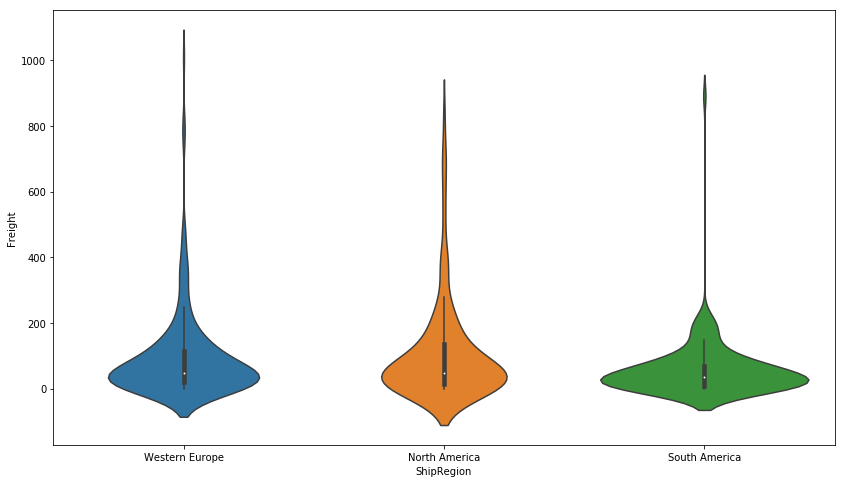

In [240]:
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='ShipRegion', y='Freight', data=top3list)

high power, low beta, which means probability of a type 2 error is small

In [205]:
#Lets look at their top 3 Regions (Western Europe, North America, and South America) by ShipVia to see the effect on Freight

In [211]:
western_europe_shipvia1 = df2[(df2['ShipRegion'] == 'Western Europe') & (df2['ShipVia'] == 1)]['Freight']
western_europe_shipvia2 = df2[(df2['ShipRegion'] == 'Western Europe') & (df2['ShipVia'] == 2)]['Freight']
western_europe_shipvia3 = df2[(df2['ShipRegion'] == 'Western Europe') & (df2['ShipVia'] == 3)]['Freight']

north_america_shipvia1 = df2[(df2['ShipRegion'] == 'North America') & (df2['ShipVia'] == 1)]['Freight']
north_america_shipvia2 = df2[(df2['ShipRegion'] == 'North America') & (df2['ShipVia'] == 2)]['Freight']
north_america_shipvia3 = df2[(df2['ShipRegion'] == 'North America') & (df2['ShipVia'] == 3)]['Freight']

south_america_shipvia1 = df2[(df2['ShipRegion'] == 'South America') & (df2['ShipVia'] == 1)]['Freight']
south_america_shipvia2 = df2[(df2['ShipRegion'] == 'South America') & (df2['ShipVia'] == 2)]['Freight']
south_america_shipvia3 = df2[(df2['ShipRegion'] == 'South America') & (df2['ShipVia'] == 3)]['Freight']

In [225]:
sp.stats.f_oneway(western_europe_shipvia1,western_europe_shipvia2,western_europe_shipvia3)

F_onewayResult(statistic=1.1045786972444605, pvalue=0.3328266640005157)

In [223]:
sp.stats.f_oneway(north_america_shipvia1, north_america_shipvia2, north_america_shipvia3)

F_onewayResult(statistic=0.9897518045725815, pvalue=0.37409896448344915)

In [224]:
sp.stats.f_oneway(south_america_shipvia1, south_america_shipvia2, south_america_shipvia3)

F_onewayResult(statistic=1.1767621980719847, pvalue=0.31126310346899183)

It appears that the ShipRegion combined with ShipVia doesnt have a statistically signficiant effect on Freight

Hypothesis test 4: 

Null Hypothesis: H_0 = UnitPrice does not have a statistically significant relationship with Quantity

Alternative Hypothesis: H_1 = UnitPrice does have a statistically significant relationship with Quantity

In [63]:
#wrap the results into a Pandas DataFrame and re-assign column names
c.execute('''SELECT * FROM OrderDetail ORDER BY UnitPrice DESC;''')
df3 = pd.DataFrame(c.fetchall())
df3.columns = [column[0] for column in c.description]
df3.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10518/38,10518,38,263.5,15,0.00
1,10540/38,10540,38,263.5,30,0.00
2,10541/38,10541,38,263.5,4,0.10
3,10616/38,10616,38,263.5,15,0.05
4,10672/38,10672,38,263.5,15,0.10


In [64]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


what is the difference between "smaller" and "larger" under the alternative field of power_analysis.solve_power?

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

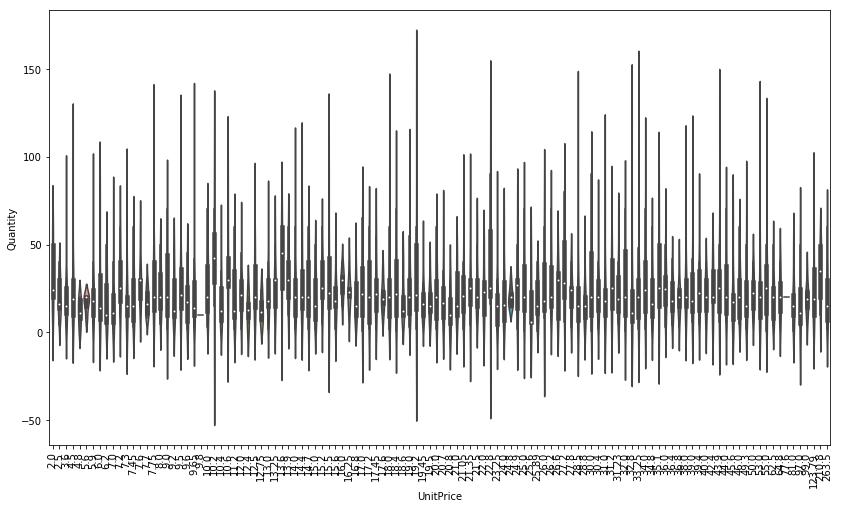

In [71]:
#create a violin plot in seaborn to compare the different discount levels
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='UnitPrice', y='Quantity', data=df3)
plt.xticks(rotation=90)
#ax.set(ylim=(-50,200))

In [72]:
np.percentile(df3.UnitPrice, 25)

12.0

In [73]:
np.percentile(df3.UnitPrice, 50)

18.4

In [74]:
np.percentile(df3.UnitPrice, 75)

32.0

In [75]:
price1 = df3[df3.UnitPrice <= 12]['Quantity']

In [76]:
price1.mean()

23.040072859744992

In [77]:
price2 = df3[(df3.UnitPrice > 12) & (df3.UnitPrice <= 18.4)]['Quantity']

In [78]:
price2.mean()

24.476014760147603

In [79]:
price3 = df3[(df3.UnitPrice > 18.4) & (df3.UnitPrice <= 32)]['Quantity']

In [80]:
price3.mean()

23.534709193245778

In [81]:
price4 = df3[df3.UnitPrice > 32]['Quantity']

In [82]:
price4.mean()

24.214689265536723

In [83]:
#try an ANOVA test for each quartile of prices
sp.stats.f_oneway(price1, price2, price3, price4)

F_onewayResult(statistic=0.6382658769320135, pvalue=0.5903639373068829)

the p value is >0.05, fail to reject the null hypothesis

When running the different combinations of price quartiles in t-tests you can see that none of them are statistically significant. This means that the price of an item doesn't have a significant relationship with the Quantity of an order. This supports the small effect size seen above. Customers don't seem to want more of an item just because its a lower price.


My recommendation to the company would be to put a discount level on the item instead of just lowering the price because it seems to have more of an effect on Quantity of an order. 

I would also recommend to investigate further to see how prices, profitability, and discount levels play a part in a customer's decision to place an order with a certain quantity.

Hypothesis Test 5

In [162]:
#wrap the results into a Pandas DataFrame and re-assign column names
c.execute('''SELECT Product.Id,
Product.ProductName,
Product.UnitPrice AS UnitCost,
OrderDetail.OrderId,
OrderDetail.ProductId,
OrderDetail.UnitPrice AS UnitRevenue,
OrderDetail.Quantity,
OrderDetail.Discount
FROM Product 
JOIN OrderDetail
ON Product.Id = OrderDetail.ProductId;''')
df4 = pd.DataFrame(c.fetchall())
df4.columns = [column[0] for column in c.description]
df4.head()

,Id,ProductName,UnitCost,OrderId,ProductId,UnitRevenue,Quantity,Discount
0,11,Queso Cabrales,21.00,10248,11,14.0,12,0.0
1,42,Singaporean Hokkien Fried Mee,14.00,10248,42,9.8,10,0.0
2,72,Mozzarella di Giovanni,34.80,10248,72,34.8,5,0.0
3,14,Tofu,23.25,10249,14,18.6,9,0.0
4,51,Manjimup Dried Apples,53.00,10249,51,42.4,40,0.0


In [163]:
df4['UnitRevenuePostDiscount'] = df4['UnitRevenue']*(1-df4['Discount'])

In [164]:
df4['UnitGrossProfit'] = df4['UnitRevenuePostDiscount'] - df4['UnitCost'] 

In [170]:
df4['TotalRevenue'] = df4['UnitRevenuePostDiscount']*df4['Quantity']

In [171]:
df4['TotalCost'] = df4['UnitCost']*df4['Quantity']

In [174]:
df4['TotalProfit'] = df4['TotalRevenue'] - df4['TotalCost']

In [175]:
df4.head()

,Id,ProductName,UnitCost,OrderId,ProductId,UnitRevenue,Quantity,Discount,UnitRevenuePostDiscount,UnitGrossProfit,TotalRevenue,TotalCost,TotalProfit
0,11,Queso Cabrales,21.00,10248,11,14.0,12,0.0,14.0,-7.00,168.0,252.00,-84.00
1,42,Singaporean Hokkien Fried Mee,14.00,10248,42,9.8,10,0.0,9.8,-4.20,98.0,140.00,-42.00
2,72,Mozzarella di Giovanni,34.80,10248,72,34.8,5,0.0,34.8,0.00,174.0,174.00,0.00
3,14,Tofu,23.25,10249,14,18.6,9,0.0,18.6,-4.65,167.4,209.25,-41.85
4,51,Manjimup Dried Apples,53.00,10249,51,42.4,40,0.0,42.4,-10.60,1696.0,2120.00,-424.00


Company isn't profitable on any Products, so I guess they just want to increase Quantity to get their UnitCost down by ordering more in bulk

Hyothesis Test 6:

In [181]:
c.execute('''SELECT Product.Id,
Product.ProductName,
Product.CategoryId,
Product.UnitPrice AS UnitCost,
OrderDetail.OrderId,
OrderDetail.ProductId,
OrderDetail.UnitPrice,
OrderDetail.Quantity,
OrderDetail.Discount
FROM Product
JOIN OrderDetail
ON Product.Id = OrderDetail.ProductId;''')
df5 = pd.DataFrame(c.fetchall())
df5.columns = [column[0] for column in c.description]
df5.head()

,Id,ProductName,CategoryId,UnitCost,OrderId,ProductId,UnitPrice,Quantity,Discount
0,11,Queso Cabrales,4,21.00,10248,11,14.0,12,0.0
1,42,Singaporean Hokkien Fried Mee,5,14.00,10248,42,9.8,10,0.0
2,72,Mozzarella di Giovanni,4,34.80,10248,72,34.8,5,0.0
3,14,Tofu,7,23.25,10249,14,18.6,9,0.0
4,51,Manjimup Dried Apples,7,53.00,10249,51,42.4,40,0.0


In [182]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 9 columns):
Id             2155 non-null int64
ProductName    2155 non-null object
CategoryId     2155 non-null int64
UnitCost       2155 non-null float64
OrderId        2155 non-null int64
ProductId      2155 non-null int64
UnitPrice      2155 non-null float64
Quantity       2155 non-null int64
Discount       2155 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 151.6+ KB


In [183]:
df5.CategoryId.value_counts()

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

In [186]:
#create sample groups based on Quantites of different product categories
category1 = df5[df5.CategoryId == 1]['Quantity']
category2 = df5[df5.CategoryId == 2]['Quantity']
category3 = df5[df5.CategoryId == 3]['Quantity']
category4 = df5[df5.CategoryId == 4]['Quantity']
category5 = df5[df5.CategoryId == 5]['Quantity']
category6 = df5[df5.CategoryId == 6]['Quantity']
category7 = df5[df5.CategoryId == 7]['Quantity']
category8 = df5[df5.CategoryId == 8]['Quantity']

Null Hypothesis: H_0 = CategoryId doesn't effect Quantity

Alternative Hypothesis: H_1 = CategoryId does effect Quantity

one-tail test

alpha = 0.05

In [189]:
#initial sample mean exploration
categorylist = [category1, category2, category3, category4, category5, category6, category7, category8]

for category in categorylist:
    print(category.mean())

23.594059405940595
24.52777777777778
23.67065868263473
24.997267759562842
23.275510204081634
24.271676300578033
21.985294117647058
23.275757575757577


In [190]:
sp.stats.f_oneway(category1, category2, category3, category4, category5, category6, category7, category8)

F_onewayResult(statistic=0.5094291432034348, pvalue=0.8280581155634347)

Reject the null hypothesis because our p-value > 0.05, categories don't have a significant effect on Quantity.

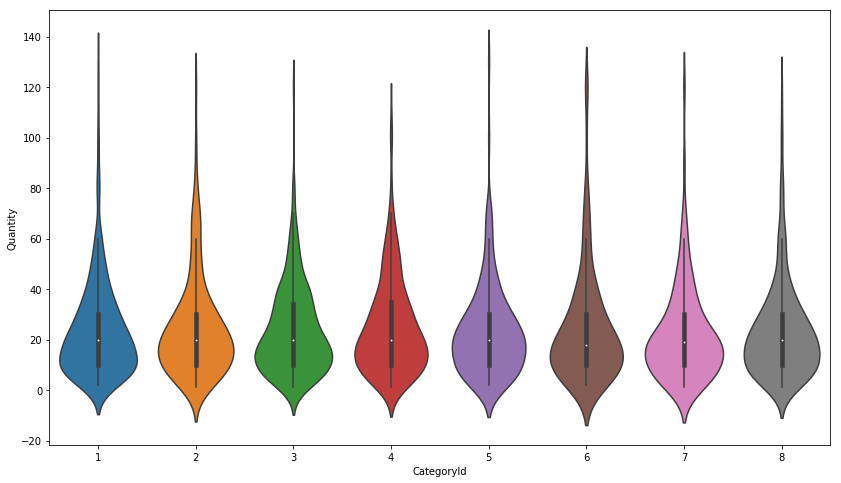

In [191]:
#create a violin plot in seaborn to compare the different discount levels
plt.subplots(figsize=(14,8))
ax = sns.violinplot(x='CategoryId', y='Quantity', data=df5)

This visualization further emphasizes that CategoryId doesn't have a significant effect on Quantity.